In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from keras import Model
from keras.layers import Input, LSTM, Dense

In [2]:
num_samples = 10000
latent_dim = 256 # size of hidden_state and cell_state of RNN
batch_size = 64
epochs = 100

In [ ]:
input_txt_list = []
target_txt_list = []
input_char_list = set()
target_char_list = set(['\t','\n']) # /t and /n are start and end character

with open('/content/fra.txt', 'r', encoding = 'utf-8') as f:
  lines = f.read().split('\n')
  for line in lines[:min(num_samples, len(lines) - 1)]:
    input_txt, target_txt, _ = line.split('\t')

    input_txt_list.append(input_txt)
    for ch in input_txt:
      if ch not in input_char_list:
        input_char_list.add(ch)

    target_txt_list.append('\t'+target_txt+'\n')
    for ch in target_txt:
      if ch not in target_char_list:
        target_char_list.add(ch)

In [4]:
input_txt_list[:10]

['Go.', 'Go.', 'Go.', 'Go.', 'Hi.', 'Hi.', 'Run!', 'Run!', 'Run!', 'Run!']

In [5]:
target_txt_list[:10]

['\tVa !\n',
 '\tMarche.\n',
 '\tEn route !\n',
 '\tBouge !\n',
 '\tSalut !\n',
 '\tSalut.\n',
 '\tCours\u202f!\n',
 '\tCourez\u202f!\n',
 '\tPrenez vos jambes à vos cous !\n',
 '\tFile !\n']

In [6]:
input_char_dict = {}
for ch in input_char_list:
  input_char_dict[ch] = len(input_char_dict)

target_char_dict = {}
for ch in target_char_list:
  target_char_dict[ch] = len(target_char_dict)

# Used during translation
reversed_target_char_dict = dict(zip(target_char_dict.values(), target_char_dict.keys()))

In [7]:
max_input_sentence_length = max([ len(sentence) for sentence in input_txt_list ])
max_target_sentence_length = max([ len(sentence) for sentence in target_txt_list ])
num_input_characters = len(input_char_list)
num_target_characters = len(target_char_list)
num_pairs = len(input_txt_list)

In [8]:
print("max_input_sentence_length = ", max_input_sentence_length)
print("max_target_sentence_length = ", max_target_sentence_length)
print("num_input_characters = ", num_input_characters)
print("num_target_characters = ", num_target_characters)
print("num_pairs = ", num_pairs)

max_input_sentence_length =  14
max_target_sentence_length =  59
num_input_characters =  70
num_target_characters =  91
num_pairs =  10000


In [9]:
encoder_input_data = np.zeros(shape = (num_pairs, max_input_sentence_length, num_input_characters))
decoder_input_data = np.zeros(shape = (num_pairs, max_target_sentence_length, num_target_characters))
decoder_target_data = np.zeros(shape = (num_pairs, max_target_sentence_length, num_target_characters))

In [10]:
for i,(input_txt, target_txt) in enumerate(zip(input_txt_list, target_txt_list)):
  for t, ch in enumerate(input_txt):
    encoder_input_data[i, t, input_char_dict[ch]] = 1
  encoder_input_data[i, t+1:, input_char_dict[' ']] = 1

  for t, ch in enumerate(target_txt):
    decoder_input_data[i, t, target_char_dict[ch]] = 1
    if(t>0):
      decoder_target_data[i, t-1, target_char_dict[ch]] = 1 # will leave the first character that is start symbol
  decoder_input_data[i, t+1:, target_char_dict[' ']] = 1
  decoder_target_data[i, t:, target_char_dict[' ']] = 1

In [11]:
num_encoder_token = num_input_characters
num_decoder_token = num_target_characters

In [12]:
encoder_input = Input(shape = (None, num_encoder_token))
# return_state=True means it woult return hidden state and cell state along with final output
encoder = LSTM(latent_dim, return_state = True)

# state_h and state_c are final hidden and cell state of encoder
encoder_output, state_h, state_c = encoder(encoder_input)
encoder_final_state = [state_h, state_c]

decoder_input = Input(shape = (None, num_decoder_token))
# return_sequences=True means it would return all timestamps outputs
decoder = LSTM(latent_dim, return_sequences=True, return_state = True)
decoder_output, _ , _  = decoder(decoder_input, initial_state = encoder_final_state)
decoder_dense = Dense(num_decoder_token, 'softmax')
decoder_output = decoder_dense(decoder_output)

model = Model([encoder_input,decoder_input], decoder_output)

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [14]:
history = model.fit(
    x = [encoder_input_data, decoder_input_data],
    y = decoder_target_data,
    batch_size = batch_size,
    epochs=epochs,
    validation_split=0.2
)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - acc: 0.7049 - loss: 1.8965 - val_acc: 0.7006 - val_loss: 1.1344
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.7419 - loss: 0.9740 - val_acc: 0.7298 - val_loss: 0.9526
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - acc: 0.7714 - loss: 0.8341 - val_acc: 0.7677 - val_loss: 0.8489
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.8005 - loss: 0.7387 - val_acc: 0.7919 - val_loss: 0.7446
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.8164 - loss: 0.6727 - val_acc: 0.7992 - val_loss: 0.7155
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.8224 - loss: 0.6230 - val_acc: 0.8089 - val_loss: 0.6640
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - acc: 0.8328 - loss: 0.5795 - val_acc: 0.8164 - val_loss: 0.6335
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - acc: 0.8409 - loss: 0.5487 - val_acc: 0.8219 - val_loss: 0.6118
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━

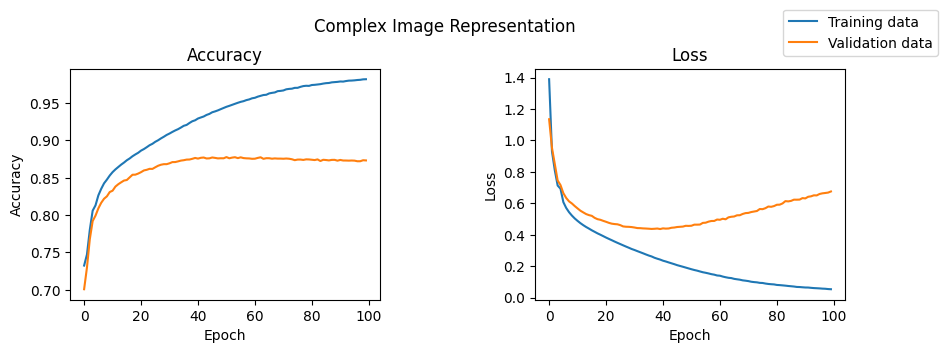

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'wspace': 0.5})

ax1.plot(history.history['acc'], label='Training data')
ax1.plot(history.history['val_acc'], label='Validation data')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy')

# Plot loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Loss')

fig.legend(bbox_to_anchor = (1,1.10))
fig.suptitle("Complex Image Representation", y=1.05)
plt.show()

In [16]:
# As our model is trained on on 'teacher forcing method' it by defaults input the ground truth vector as input to the decoder at each
# timestamp and would do same during inference which is not the desired behaviour as now we only have input_seq and not ground_truth
# along with it

# So during the inference we would generate each output and manually create the next input and state for the decoder and give the as input
# decoder_dense and decoder retain their trained weights after the training

encoder_model = Model(encoder_input, encoder_final_state)


decoder_input_state_h = Input(shape =  (latent_dim,))
decoder_input_state_c = Input(shape =  (latent_dim,))
decoder_output, decoder_output_state_h, decoder_output_state_c = decoder(decoder_input, initial_state = [decoder_input_state_h, decoder_input_state_c])
decoder_output = decoder_dense(decoder_output)
decoder_model = Model([decoder_input, decoder_input_state_h, decoder_input_state_c], [decoder_output, decoder_output_state_h, decoder_output_state_c])


In [17]:
def TxtToSeq(txt, max_input_sentence_length, num_input_characters, input_char_dict):
  seq = np.zeros(shape = (1, max_input_sentence_length, num_input_characters))
  for t, ch in enumerate(txt):
    seq[0, t, input_char_dict[ch]] = 1
  seq[0, t+1:, input_char_dict[' ']] = 1
  return seq

In [18]:
def predict(input_seq):
  state_h, state_c  = encoder_model(input_seq)
  target_seq = np.zeros(shape = (1, 1, num_target_characters))
  target_seq[0, 0, target_char_dict['\t']] = 1

  stop = False
  decoded_sentence = '';
  while not stop:
    out, h, c = decoder_model.predict([target_seq, state_h, state_c])
    idx = np.argmax(out[0,0,:])
    ch = reversed_target_char_dict[idx]

    if(ch == '\n' or len(decoded_sentence) > max_target_sentence_length):stop = True
    decoded_sentence = decoded_sentence + ch;

    target_seq = np.zeros(shape = (1, 1, num_target_characters))
    target_seq[0, 0, target_char_dict[ch]] = 1

    state_h = h
    state_c = c

  return decoded_sentence

In [27]:
def make_prediction(txt):
  input_sentence = txt
  input_seq = TxtToSeq(input_sentence, max_input_sentence_length, num_input_characters, input_char_dict)
  decoded_sentence = predict(input_seq)
  return decoded_sentence

In [28]:
input_sentence = "Hello"
decoded_sentence = make_prediction(input_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [29]:
print("Input sentence = ", input_sentence)
print("Output sentence = ", decoded_sentence)

Input sentence =  Hello
Output sentence =  Salut.



In [30]:
input_sentence = "You've changed"
decoded_sentence = make_prediction(input_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [31]:
print("Input sentence = ", input_sentence)
print("Output sentence = ", decoded_sentence)

Input sentence =  You've changed
Output sentence =  Tu as perdu.

